# Deep Learning

In [46]:
Tensor = list
from typing import List

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes

print(f"shape([1,2,3]) = {shape([1,2,3])}")
print(f"shape([[1,2],[3,4],[5,6]]) = {shape([[1,2],[3,4],[5,6]])}")
print(f"shape([[[1,2,3], [4,5,6]],[[7,8,9],[10,11,12]],[[15,16,17],[18,19,20]]]) = {shape([[[1,2,3], [4,5,6]],[[7,8,9],[10,11,12]],[[15,16,17],[18,19,20]]])}")

shape([1,2,3]) = [3]
shape([[1,2],[3,4],[5,6]]) = [3, 2]
shape([[[1,2,3], [4,5,6]],[[7,8,9],[10,11,12]],[[15,16,17],[18,19,20]]]) = [3, 2, 3]


In [47]:
# Check if tensor is 1D or of higher dimensional
def is_1d(tensor: Tensor) -> bool:
    """If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensional (that is, a vector)."""
    return not isinstance(tensor[0], list)

print(f"is_1d([1,2,3]) = {is_1d([1,2,3])}")
print(f"is_1d([[1,2],[3,4]]) = {is_1d([[1,2],[3,4]])}")

is_1d([1,2,3]) = True
is_1d([[1,2],[3,4]]) = False


In [48]:
def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in a tensor"""
    if is_1d(tensor):
        return sum(tensor)
    else:
        return sum(tensor_sum(tensor_i) for tensor_i in tensor)
    
print(tensor_sum([[1,2],[3,4]]))

10


In [49]:
from typing import Callable
def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Applies f element-wise"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]
    
print(f"tensor_apply(lambda x: x + 1, [1,2,3]) = {tensor_apply(lambda x: x + 1, [1,2,3])}")
print(f"tensor_apply(lambda x: 2*x, [[1,2],[3,4]]) = {tensor_apply(lambda x: 2*x, [[1,2],[3,4]])}")

tensor_apply(lambda x: x + 1, [1,2,3]) = [2, 3, 4]
tensor_apply(lambda x: 2*x, [[1,2],[3,4]]) = [[2, 4], [6, 8]]


In [50]:
# Create 0 Tensor
def zero_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

print(f"zero_like([1,2,3]) = {zero_like([1,2,3])}")
print(f"zero_like([[1,2],[3,4]]) = {zero_like([[1,2],[3,4]])}")

zero_like([1,2,3]) = [0.0, 0.0, 0.0]
zero_like([[1,2],[3,4]]) = [[0.0, 0.0], [0.0, 0.0]]


In [51]:
def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x,y) for x,y in zip(t1,t2)]
    else:
        return [tensor_combine(f, tensor_i, tensor_j)
               for tensor_i, tensor_j in zip(t1, t2)]
    
import operator

print("tensor_combine(operator.add, [1,2,3], [4,5,6])" +  
      f" = {tensor_combine(operator.add, [1,2,3], [4,5,6])}")
print("tensor_combine(operator.mul, [1,2,3], [4,5,6])" +  
      f" = {tensor_combine(operator.mul, [1,2,3], [4,5,6])}")

tensor_combine(operator.add, [1,2,3], [4,5,6]) = [5, 7, 9]
tensor_combine(operator.mul, [1,2,3], [4,5,6]) = [4, 10, 18]


In [52]:
from typing import Iterable, Tuple

class Layer:
    """
    Our neural networks will be composed of Layers, each of which
    knows how to do some computation on its inputs in the "forward"
    direction and propagate gradients in the "backward" direction.
    """
    def forward(self, input):
        """
        Note the lack of types. We're not going to be prescriptive
        about what kinds of inputs layers can take and what kinds
        of outputs they can return.
        """
        raise NotImplementedError

    def backward(self, gradient):
        """
        Similarly, we're not going to be prescriptive about what the
        gradient looks like. It's up to you the user to make sure
        that you're doing things sensibly.
        """
        raise NotImplementedError

    def params(self) -> Iterable[Tensor]:
        """
        Returns the parameters of this layer. The default implementation
        returns nothing, so that if you have a layer with no parameters
        you don't have to implement this.
        """
        return ()

    def grads(self) -> Iterable[Tensor]:
        """
        Returns the gradients, in the same order as params()
        """
        return ()

In [53]:
from Neural_networks import sigmoid

class Sigmoid(Layer):
    
    def forward(self, input: Tensor) -> Tensor:
        """Applies sigmoid to each element of the input tensor,
        and save the results to use in backpropagation."""
        self.sigmoids = tensor_apply(sigmoid,input)
        return self.sigmoids
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                             self.sigmoids,
                             gradient)

In [54]:
import random
from Probability import inverse_normal_cdf

def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]
    
def random_normal(*dims: int,
                 mean: float = 0.0,
                 variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance*inverse_normal_cdf(random.random()) 
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean = mean, variance = variance)
                for _ in range(dims[0])]
    
print(f"random_normal(2,3,4) = {random_normal(2,3,4)}")

def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims,variance = variance)
    else:
        raise ValueError(f"unkown init: {init}")

random_normal(2,3,4) = [[[-1.669912338256836, 0.8742237091064453, 2.031412124633789, -0.09915351867675781], [-1.1844158172607422, -1.3951969146728516, -1.2888240814208984, 0.7239246368408203], [-0.2172374725341797, 1.3999462127685547, -0.1493549346923828, -1.424551010131836]], [[-0.18418312072753906, 0.6897640228271484, 0.9515476226806641, -1.758260726928711], [-0.9138774871826172, -0.025033950805664062, -1.1354923248291016, 1.1315631866455078], [1.509866714477539, -0.46881675720214844, -0.1640605926513672, 0.14349937438964844]]]


In [55]:
from Vector_operations_on_data import dot

class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        A layer of output_dim neurons, each with input_dim weights
        (and a bias).
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the o-th neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the o-th neuron
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass.
        self.input = input

        # Return the vector of neuron outputs.
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient.
        self.b_grad = gradient

        # Each w[o][i] multiplies input[i] and gets added to output[o].
        # So its gradient is input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Each input[i] multiplies every w[o][i] and gets added to every
        # output[o]. So its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

In [56]:
from typing import List

class Sequential(Layer):
    """
    A layer consisting of a sequence of other layers.
    It's up to you to make sure that the output of each layer
    makes sense as the input to the next layer.
    """
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Just forward the input through the layers in order."""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Just backpropagate the gradient through the layers in reverse."""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Just return the params from each layer."""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Just return the grads from each layer."""
        return (grad for layer in self.layers for grad in layer.grads())


In [57]:
xor_net = Sequential([
    Linear(input_dim = 2, output_dim = 2),
    Sigmoid(),
    Linear(input_dim = 2, output_dim = 1),
    Sigmoid()
])

In [58]:
class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """How good are our predictions? (Larger numbers are worse.)"""
        raise NotImplementedError

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """How does the loss change as the predictions change?"""
        raise NotImplementedError

class SSE(Loss):
    """Loss function that computes the sum of the squared errors."""
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Compute the tensor of squared differences
        squared_errors = tensor_combine(
            lambda predicted, actual: (predicted - actual) ** 2,
            predicted,
            actual)

        # And just add them up
        return tensor_sum(squared_errors)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return tensor_combine(
            lambda predicted, actual: 2 * (predicted - actual),
            predicted,
            actual)


sse_loss = SSE()
print(sse_loss.loss([1, 2, 3], [10, 20, 30]))
print(sse_loss.gradient([1, 2, 3], [10, 20, 30]))

1134
[-18, -36, -54]


In [59]:
class Optimizer:
    """
    An optimizer updates the weights of a layer (in place) using information
    known by either the layer or the optimizer (or by both).
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError

class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate

    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Update param using a gradient step
            param[:] = tensor_combine(
                lambda param, grad: param - grad * self.lr,
                param,
                grad)

In [60]:
class Momentum(Optimizer):
    def __init__(self,
                 learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # running average

    def step(self, layer: Layer) -> None:
        # If we have no previous updates, start with all zeros.
        if not self.updates:
            self.updates = [zero_like(grad) for grad in layer.grads()]

        for update, param, grad in zip(self.updates,
                                       layer.params(),
                                       layer.grads()):
            # Apply momentum
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad)

            # Then take a gradient step
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update)

In [61]:
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]
    
random.seed(0)
    
net = Sequential([
        Linear(input_dim=2, output_dim=2),
        Sigmoid(),
        Linear(input_dim=2, output_dim=1)
    ])
    
import tqdm
    
optimizer = GradientDescent(learning_rate=0.1)
loss = SSE()
    
with tqdm.trange(3000) as t:
    for epoch in t:
        epoch_loss = 0.0
    
        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
    
            optimizer.step(net)
    
        t.set_description(f"xor loss {epoch_loss:.3f}")

xor loss 0.000: 100%|█████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 572.63it/s]


In [62]:
for param in net.params():
    print(param)

[[-1.6425160695224112, -1.4948117798303162], [-4.567646572029666, -3.3649176350731915]]
[1.7673716823255192, 0.3872701437947276]
[[3.1986204791704025, -3.5018030621426206]]
[-0.64627659633622]


In [63]:
import math

def tanh(x: float) -> float:
    # If x is very large or very small, tanh is (essentially) 1 or -1
    # We check for this because, e.g., math.exp(1000) raises an error.
    
    if  x < -100: return -1
    elif x > 100: return 1
    
    em2x = math.exp(-2*x)
    return (1-em2x)/(1 + em2x)

class Tanh(Layer):
    def forward(self, input: Tensor) -> Tensor:
        # Save tanh output to use it in backpropagation
        self.tanh = tensor_apply(tanh, input)
        return self.tanh
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
        lambda tanh, grad: (1- tanh**2)*grad,
        self.tanh, gradient)

In [64]:
class Relu(Layer):
    def forward(self, input: Tensor) -> Tensor:
        
        self.input = input
        return tensor_apply(lambda x: max(x,0), input)
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda x, grad: grad if x > 0 else 0,
                             self.input,
                             gradient)

# Revisiting FizzBuzz

In [65]:
from Neural_networks import binary_encode, fizz_buzz_encode, argmax

xs  = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]

In [66]:
# Create Network

NUM_HIDDEN = 25
random.seed(0)

net = Sequential([
    Linear(input_dim = 10, output_dim = NUM_HIDDEN, init = 'uniform'),
    Tanh(),
    Linear(input_dim = NUM_HIDDEN, output_dim = 4, init = 'uniform'),
    Sigmoid()

])

In [67]:
# Training

def fizzbuzz_accuracy(low: int, hi: int, net: Layer) -> float:
    num_correct = 0
    
    for n in range(low, hi):
        x = binary_encode(n)
        predicted = argmax(net.forward(x))
        actual = argmax(fizz_buzz_encode(n))
        if predicted == actual:
            num_correct += 1
        
    return num_correct/(hi - low)

optimizer = Momentum(learning_rate = 0.1, momentum = 0.9)
loss = SSE()

with tqdm.trange(1000) as t:
    for epoch in t:
        epoch_loss = 0.0
        
        for x,y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
            
            optimizer.step(net)
        
        accuracy = fizzbuzz_accuracy(101, 1024, net)
        t.set_description(f"fb loss: {epoch_loss} acc: {accuracy}")

fb loss: 64.5411689216839 acc: 0.9501625135427952: 100%|███████████████████████████| 1000/1000 [08:18<00:00,  2.13it/s]


In [68]:
# Check results on the test-set
print("test_results", fizzbuzz_accuracy(1, 101, net))

test_results 0.9


# Convert hot bit encoded output to probability value using Softmax

In [69]:
import math

def softmax(tensor: Tensor) -> Tensor:
    """Softmax along the last dimension"""
    if is_1d(tensor):
        # Subtract the largest value for numerical stability
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]
        
        sum_of_exps = sum(exps) # this the total "weight"
        return [exp_i/sum_of_exps for exp_i in exps] # Probability is of total weight

In [70]:
class SoftmaxCrossEntropy(Loss):
    """
    This is the negative-log-likelihood of the obeserved values, 
    given the network model. So if we choose weights to minimize it,
    our model will be maximizing the likelihood of the observed data."""
    
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Apply softmax to get the probabilities
        probabilties = softmax(predicted)
        
        # This will be log p_i for the actual class i and 0 for the other
        # classes. We add a tiny amount to p to avoid taking log(0)
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30)*act,
                                    probabilties, actual)
        # And then we just sum up the negatives
        return -tensor_sum(likelihoods)
   
    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)
    
        return tensor_combine(lambda p, actual: p-actual,
                         probabilities, actual)

#  No final sigmoid layer now
# Training much faster

In [71]:
    
net = Sequential([
        Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
        Tanh(),
        Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform')
        # No final sigmoid layer now
    ])
    
optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SoftmaxCrossEntropy()

with tqdm.trange(100) as t:
        for epoch in t:
            epoch_loss = 0.0
    
            for x, y in zip(xs, ys):
                predicted = net.forward(x)
                epoch_loss += loss.loss(predicted, y)
                gradient = loss.gradient(predicted, y)
                net.backward(gradient)
    
                optimizer.step(net)
    
            accuracy = fizzbuzz_accuracy(101, 1024, net)
            t.set_description(f"fb loss: {epoch_loss:.3f} acc: {accuracy:.2f}")

fb loss: 129.330 acc: 0.94: 100%|████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.15it/s]


In [72]:
print("Test Results", fizzbuzz_accuracy(1,101,net))

Test Results 0.93


# Add Dropout to avoid overfitting

In [73]:
class Dropout(Layer):
    def __init__(self, p: float) -> None:
        self.p = p
        self.train = True

    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            # Create a mask of 0s and 1s shaped like the input
            # using the specified probability.
            self.mask = tensor_apply(
                lambda _: 0 if random.random() < self.p else 1,
                input)
            # Multiply by the mask to dropout inputs.
            return tensor_combine(operator.mul, input, self.mask)
        else:
            # During evaluation just scale down the outputs uniformly.
            return tensor_apply(lambda x: x * (1 - self.p), input)

    def backward(self, gradient: Tensor) -> Tensor:
        if self.train:
            # Only propagate the gradients where mask == 1
            return tensor_combine(operator.mul, gradient, self.mask)
        else:
            raise RuntimeError("don't call backward when not in train mode")

# Download MNIST data

In [74]:
# !python -m pip install mnist

In [75]:
import mnist

In [76]:
# This will download the data, change this to where you want it.
    # (Yes, it's a 0-argument function, that's what the library expects.)
    # (Yes, I'm assigning a lambda to a variable, like I said never to do.)
# mnist.temporary_dir = lambda: '/tmp'
mnist.temporary_dir = lambda: 'C:/Users/Ruchika/DSS/mnist_train/raw'

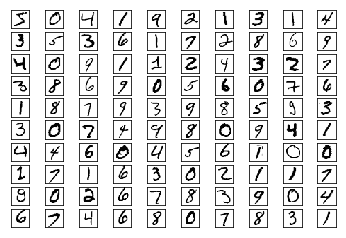

In [77]:
# Each of these functions first downloads the data and returns a numpy array.
# We call .tolist() because our "tensors" are just lists.
train_images = mnist.train_images().tolist()
train_labels = mnist.train_labels().tolist()
    
assert shape(train_images) == [60000, 28, 28]
assert shape(train_labels) == [60000]
    
import matplotlib.pyplot as plt
    
fig, ax = plt.subplots(10, 10)
    
for i in range(10):
    for j in range(10):
        # Plot each image in black and white and hide the axes.
        ax[i][j].imshow(train_images[10 * i + j], cmap='Greys')
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)
    
# plt.show()

In [78]:
# Load the MNIST test data
    
test_images = mnist.test_images().tolist()
test_labels = mnist.test_labels().tolist()
    
assert shape(test_images) == [10000, 28, 28]
assert shape(test_labels) == [10000]

In [79]:
shape(train_images)

[60000, 28, 28]

In [80]:
# Recenter the images
    
# Compute the average pixel value
avg = tensor_sum(train_images) / 60000 / 28 / 28
    
# Recenter, rescale, and flatten
train_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                    for image in train_images]
test_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                   for image in test_images]
    
assert shape(train_images) == [60000, 784], "images should be flattened"
assert shape(test_images) == [10000, 784], "images should be flattened"
    
# After centering, average pixel should be very close to 0
assert -0.0001 < tensor_sum(train_images) < 0.0001

In [81]:
# One-hot encode the test data
def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
    return [1.0 if j == i else 0.0 for j in range(num_labels)]

assert one_hot_encode(3) == [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
assert one_hot_encode(2, num_labels=5) == [0, 0, 1, 0, 0]
    
train_labels = [one_hot_encode(label) for label in train_labels]
test_labels = [one_hot_encode(label) for label in test_labels]
    
assert shape(train_labels) == [60000, 10]
assert shape(test_labels) == [10000, 10]

# Logistic regression model for MNIST

In [83]:
# Training loop    
import tqdm
    
def loop(model: Layer,
            images: List[Tensor],
             labels: List[Tensor],
             loss: Loss,
             optimizer: Optimizer = None) -> None:
    correct = 0         # Track number of correct predictions.
    total_loss = 0.0    # Track total loss.
    
    with tqdm.trange(len(images)) as t:
        for i in t:
            predicted = model.forward(images[i])             # Predict.
            if argmax(predicted) == argmax(labels[i]):       # Check for
                correct += 1                                 # correctness.
            total_loss += loss.loss(predicted, labels[i])    # Compute loss.
    
            # If we're training, backpropagate gradient and update weights.
            if optimizer is not None:
                gradient = loss.gradient(predicted, labels[i])
                model.backward(gradient)
                optimizer.step(model)
    
            # And update our metrics in the progress bar.
            avg_loss = total_loss / (i + 1)
            acc = correct / (i + 1)
            t.set_description(f"mnist loss: {avg_loss:.3f} acc: {acc:.3f}")
    
    
# The logistic regression model for MNIST
    
random.seed(0)
    
# Logistic regression is just a linear layer followed by softmax
model = Linear(784, 10)
loss = SoftmaxCrossEntropy()
    
# This optimizer seems to work
optimizer = Momentum(learning_rate=0.01, momentum=0.99)
    
# Train on the training data
loop(model, train_images, train_labels, loss, optimizer)
    
# Test on the test data (no optimizer means just evaluate)
loop(model, test_images, test_labels, loss)

mnist loss: 0.361 acc: 0.891: 100%|█████████████████████████████████████████████| 10000/10000 [00:20<00:00, 498.65it/s]


# Deep neural network for MNIST

In [85]:
# A deep neural network for MNIST
    
random.seed(0)
    
# Name them so we can turn train on and off
dropout1 = Dropout(0.1)
dropout2 = Dropout(0.1)
    
model = Sequential([
        Linear(784, 30),  # Hidden layer 1: size 30
        dropout1,
        Tanh(),
        Linear(30, 10),   # Hidden layer 2: size 10
        dropout2,
        Tanh(),
        Linear(10, 10)    # Output layer: size 10
    ])
    
    
# Training the deep model for MNIST
    
optimizer = Momentum(learning_rate=0.01, momentum=0.99)
loss = SoftmaxCrossEntropy()
    
# Enable dropout and train (takes > 20 minutes on my laptop!)
dropout1.train = dropout2.train = True
loop(model, train_images, train_labels, loss, optimizer)
    
# Disable dropout and evaluate
dropout1.train = dropout2.train = False
loop(model, test_images, test_labels, loss)

mnist loss: 0.313 acc: 0.908: 100%|█████████████████████████████████████████████| 10000/10000 [00:47<00:00, 211.87it/s]


In [86]:
# Save Model
import json

def save_weights(model: Layer, filename: str) -> None:
    weights = list(model.params())
    with open(filename, 'w') as f:
        json.dump(weights, f)

In [87]:
# Load Model
def load_weights(model: Layer, filename: str) -> None:
    with open(filename) as f:
        weights = json.load(f)

    # Check for consistency
    assert all(shape(param) == shape(weight)
               for param, weight in zip(model.params(), weights))

    # Then load using slice assignment:
    for param, weight in zip(model.params(), weights):
        param[:] = weight